In [7]:
import os
import sys
import numpy as np
import hydra

from cliport.dataset import RavensDataset
from cliport.utils import utils
from cliport import tasks
from cliport.environments.environment import Environment
import clip
from PIL import Image
import torch

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [8]:
### task settings
mode = 'train'
augment = True

### Uncomment the task you want to generate ###
#task = 'stack-block-pyramid-seq-seen-colors'
#task = 'packing-shapes-train'
task = 'packing-seen-google-objects-seq'

### visualization settings
max_episodes = 1
max_steps = 100

In [9]:
# Load configs
root_dir = '/home/jlin/cliport'
config_file = 'train.yaml' 
cfg = utils.load_hydra_config(os.path.join(root_dir, f'cliport/cfg/{config_file}'))

# Override defaults
cfg['task'] = task
cfg['mode'] = mode

data_dir = os.path.join(root_dir, 'data')

In [10]:
task = tasks.names[cfg['task']]()
task.mode = mode

ds = RavensDataset(os.path.join(data_dir, f'{cfg["task"]}-{cfg["mode"]}'), cfg, augment=augment)

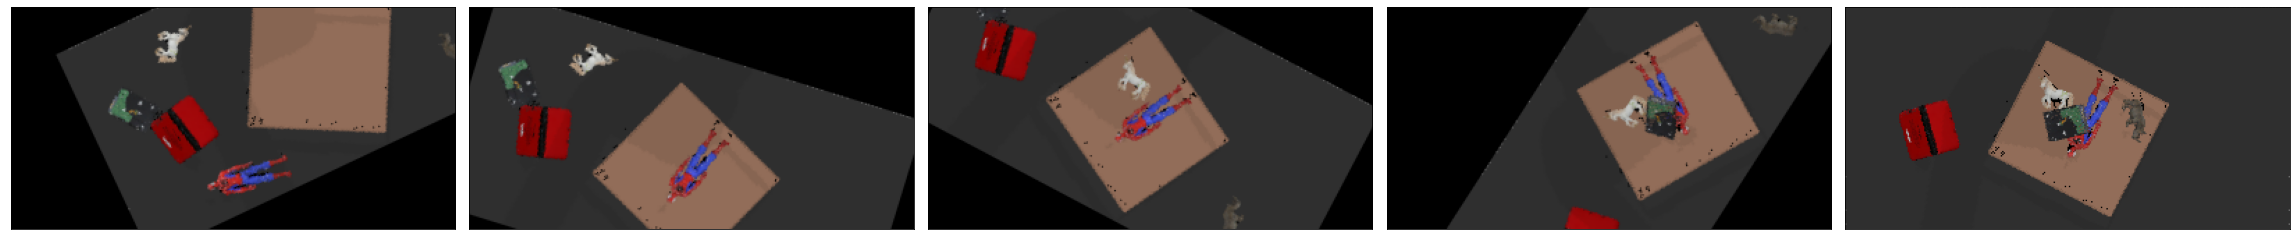

In [11]:
total_images = 0

episode, seed = ds.load(0)

total_images += len(episode)-1

total_reward = 0

fig = plt.figure(figsize=(32, 32))
columns = len(episode)
rows = 1
episode_images = []
episode_descrptions = []
for step in range(min(max_steps, len(episode))):
    obs, act, reward, info = episode[step]
    
    num_images = len(obs['color'])
    
    cam_config = None
    if b'camera_info' in info:
        cam_config = ds.get_cam_config(info[b'camera_info'])
    
    img_depth = ds.get_image(obs, cam_config=cam_config)
    img_tensor = torch.from_numpy(img_depth)
    img = np.uint8(img_tensor.detach().cpu().numpy())
    img = img.transpose(1,0,2)
    
    if step < len(episode)-1 and episode[step]:
        batch = ds.process_sample(episode[step], augment=augment)
    else:
        batch = ds.process_goal(episode[step], perturb_params=None)

    img_sample = batch['img']
    img_sample = torch.from_numpy(img_sample)
    color = np.uint8(img_sample.detach().cpu().numpy())[:,:,:3]
    color = color.transpose(1,0,2)
    episode_images.append(color)
    episode_descrptions.append(batch['lang_goal'])
    fig.add_subplot(rows, columns, step + 1)
    ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.imshow(color)
    
plt.tight_layout()
plt.show()


In [16]:
def convert_action_description_to_pre_and_post_conditions(text):
    text_tokens = text.split()
    text_tokens = text_tokens[1:]
    text_tokens = ' '.join(text_tokens)
    return text_tokens

In [17]:
processed_text = []
for i in range(len(episode_descrptions)-1):
    processed_text.append(convert_action_description_to_pre_and_post_conditions(episode_descrptions[i]))

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

processed_images = []
for i in range(len(episode_images)):
    image = preprocess(Image.fromarray(np.uint8(episode_images[i]))).unsqueeze(0).to(device)
    processed_images.append(image)
processed_images = torch.cat(processed_images)
text = clip.tokenize(processed_text).to(device)

with torch.no_grad():
    logits_per_image, logits_per_text = model(processed_images, text)
    probs = logits_per_text.softmax(dim=-1).cpu().numpy()

print(probs)

[[0.07817475 0.11118674 0.3669448  0.0363903  0.4073035 ]
 [0.00259116 0.14243136 0.581729   0.20369262 0.06955585]
 [0.13808165 0.27412146 0.20022094 0.3634326  0.02414332]
 [0.01233544 0.1874241  0.342815   0.23745105 0.21997438]]


In [19]:
processed_text

['the spiderman figure is in the brown box',
 'the unicorn toy is in the brown box',
 'the hard drive is in the brown box',
 'the rhino figure is in the brown box']

In [52]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

processed_images = []
for i in range(len(episode_images)):
    image = preprocess(Image.fromarray(np.uint8(episode_images[i]))).unsqueeze(0).to(device)
    processed_images.append(image)
processed_images = torch.cat(processed_images)
text = clip.tokenize(episode_descrptions).to(device)

with torch.no_grad():
    logits_per_image, logits_per_text = model(processed_images, text)
    probs = logits_per_text.softmax(dim=-1).cpu().numpy()

print(probs)

[[0.1537  0.2827  0.1854  0.0737  0.1235  0.05228 0.0247  0.104  ]
 [0.07806 0.29    0.2405  0.06573 0.1844  0.05536 0.02202 0.0637 ]
 [0.1026  0.2385  0.2104  0.0994  0.11444 0.0524  0.02325 0.1589 ]
 [0.1026  0.2385  0.2104  0.0994  0.11444 0.0524  0.02325 0.1589 ]
 [0.1276  0.2203  0.169   0.05487 0.1538  0.07043 0.04767 0.1562 ]
 [0.0543  0.1956  0.205   0.1547  0.2081  0.079   0.04572 0.0578 ]
 [0.10645 0.0535  0.03247 0.03348 0.04648 0.0803  0.072   0.575  ]
 [0.03937 0.1104  0.05298 0.11755 0.04062 0.02835 0.02315 0.5874 ]]


In [12]:
episode_descrptions

['pack the spiderman figure in the brown box',
 'pack the unicorn toy in the brown box',
 'pack the hard drive in the brown box',
 'pack the rhino figure in the brown box',
 'done packing objects.']